# V<sub>oc</sub> and V<sub>mp</sub> vs Irradiance

This evaluation will use a PV module approximating a Rich Solar 200W 12V panel

In [3]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Get Module Parameters
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Create a dictionary of the parameters to represent the 12V Rich Solar module
# Scale the paremters that can be easily scaled
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c']*2,
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
}

# Caculate the remaining parameters for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
                                                                         celltype='monoSi',
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s']
                                                                         )

# Add the calculated parameters to the dictionary representing the 12V Rich Solar module
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

         i_sc       v_oc       i_mp       v_mp        p_mp        i_x  \
0   11.607142  21.206206  10.798130  16.961262  183.149915  11.551512   
1    9.286868  20.970797   8.648906  16.972221  146.791138   9.243058   
2    6.966017  20.667302   6.492903  16.920051  109.860249   6.933731   
3    4.644589  20.239549   4.331016  16.751595   72.551419   4.623533   
4    2.322583  19.508301   2.164642  16.297798   35.278903   2.312403   
5    1.161364  18.777053   1.080782  15.727123   16.997594   1.156424   
6    0.580700  18.045805   0.539278  15.098799    8.142454   0.578294   
7    0.290355  17.314557   0.268958  14.442674    3.884472   0.289176   
8    0.139371  16.540243   0.128698  13.734139    1.767561   0.138813   
9    0.104529  16.236747   0.096395  13.454601    1.296951   0.104110   
10   0.069686  15.808994   0.064135  13.059818    0.837585   0.069406   
11   0.034843  15.077746   0.031947  12.384290    0.395643   0.034701   
12   0.023229  14.649993   0.021247  11.989399    0

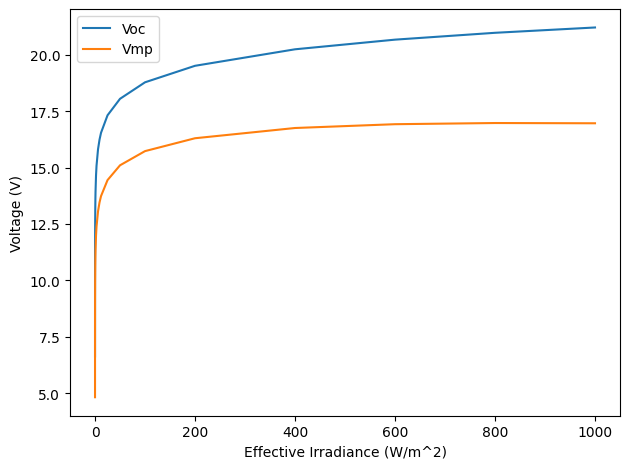

In [22]:
Temp = 50
EgRef = 1.121
dEgdT = -0.0002677

cases = [
    (1000, Temp),
    (800, Temp),
    (600, Temp),
    (400, Temp),
    (200, Temp),
    (100, Temp),
    (50, Temp),
    (25, Temp),
    (12, Temp),
    (9, Temp),
    (6, Temp),
    (3, Temp),
    (2, Temp),
    (1, Temp),
    (0.75, Temp),
    (0.5, Temp),
    (0.25, Temp),
    (0.125, Temp),
    (0.1, Temp),
    (0.075, Temp),
    (0.05, Temp),
    (0.025, Temp),
    (0.0125, Temp),
    (0.009, Temp),
    (0.006, Temp),
    (0.003, Temp),
    (0.002, Temp),
    (0.001, Temp)
]

conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    conditions['Geff'],
    conditions['Tcell'],
    alpha_sc=rich_solar_12V_params['alpha_sc'],
    a_ref=rich_solar_12V_params['a_ref'],
    I_L_ref=rich_solar_12V_params['I_L_ref'],
    I_o_ref=rich_solar_12V_params['I_o_ref'],
    R_sh_ref=rich_solar_12V_params['R_sh_ref'],
    R_s=rich_solar_12V_params['R_s'],
    EgRef=EgRef, 
    dEgdT=-dEgdT
)

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)
print(curve_info)

plt.figure()
plt.plot(conditions['Geff'],curve_info['v_oc'], label='Voc')
plt.plot(conditions['Geff'],curve_info['v_mp'], label='Vmp')
#label the axes
plt.xlabel('Effective Irradiance (W/m^2)')
plt.ylabel('Voltage (V)')
plt.legend()

v = pd.DataFrame(np.linspace(0., curve_info['v_oc'], 100))
i = pd.DataFrame(pvlib.pvsystem.i_from_v(voltage=v, method='lambertw', **SDE_params))


# plot the calculated curves:
# plt.figure()
# for idx, case in conditions.iterrows():
#     label = (
#         "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
#         "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
#     )
#     plt.plot(v[idx], i[idx], label=label)
#     v_mp = curve_info['v_mp'][idx]
#     i_mp = curve_info['i_mp'][idx]
#     # mark the MPP
#     plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')
#     plt.text(v_mp * 1.02, i_mp, f"$V_{{mp}}${v_mp:.2f} V", fontsize=8)
#     plt.text(v_mp * 1.02, i_mp - 0.3, f"$P_{{mp}}${i_mp*v_mp*2:.2f} W", fontsize=8)

# plt.legend(loc=(1.0, 0))
# plt.xlabel('Module voltage [V]')
# plt.ylabel('Module current [A]')
# plt.title(rich_solar_12V_params['Name'] + " (2 in series)")
plt.gcf().set_tight_layout(True)